# Introduction to Bayesian Statistics
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CosmoStat/z2C-Workshop/bayes_intro.ipynb)

In [ ]:
%pip install -q numpyro getdist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.1/826.1 kB 14.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!python -c "import jax; print(jax.default_backend(), jax.devices())"
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.10' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util
from jax.tree_util import tree_map

import numpyro
import numpyro.distributions as dist
from numpyro import sample, deterministic, plate, infer
from numpyro.handlers import seed, condition, trace
from numpyro.infer.util import log_density
from functools import partial
from getdist import plots, MCSamples

from scipy.stats import beta, norm, multivariate_normal, chi2
from scipy.linalg import schur, eigh
from scipy.spatial.transform import Rotation as R

%matplotlib inline
%load_ext autoreload
%autoreload 2

cpu [CpuDevice(id=0)]


$% Calligraphic capitals$
$\newcommand{\cA}{\mathcal{A}}$
$\newcommand{\cB}{\mathcal{B}}$
$\newcommand{\cC}{\mathcal{C}}$
$\newcommand{\cF}{\mathcal{F}}$
$\newcommand{\cH}{\mathcal{H}}$
$\newcommand{\cL}{\mathcal{L}}$
$\newcommand{\cM}{\mathcal{M}}$
$\newcommand{\cN}{\mathcal{N}}$
$\newcommand{\cO}{\mathcal{O}}$
$\newcommand{\cR}{\mathcal{R}}$
$\newcommand{\cS}{\mathcal{S}}$
$\newcommand{\cT}{\mathcal{T}}$
$\newcommand{\cU}{\mathcal{U}}$
$\newcommand{\cW}{\mathcal{W}}$
$\newcommand{\cX}{\mathcal{X}}$
$\newcommand{\cY}{\mathcal{Y}}$
$\newcommand{\cZ}{\mathcal{Z}}$
$% Double bars$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\KK}{\mathbb{K}}$
$\newcommand{\NN}{\mathbb{N}}$
$\newcommand{\CC}{\mathbb{C}}$
$% Greek letters$
$\newcommand{\eps}{\varepsilon}$
$\newcommand{\ph}{\varphi}$
$% Operators$
$\newcommand{\PP}{\mathbb{P}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\OO}{\mathbb{O}}$
$\newcommand{\Var}{\operatorname{\mathbb{V}\!ar}}$
$\newcommand{\Cov}{\operatorname{\mathbb{C}\!ov}}$
$% Misc$
$\newcommand{\dd}{\mathrm{d}}$
$\newcommand{\T}{^\top}  % or ^\intercal$
$\newcommand{\1}{\mathds{1}} % indicator$
$\newcommand{\voones}{\boldsymbol{j}} % vector of ones$
$\newcommand{\moones}{\boldsymbol{J}} % matrix of ones$
$\newcommand{\intint}[2]{\llbracket #1,#2 \rrbracket} % integer interval$
$% Random variables$
$\newcommand{\lat}{x} % latent value$
$\newcommand{\Lat}{X} % latent variable$
$\newcommand{\Ls}{\mathcal X} % latent space$
$\newcommand{\obs}{y} % observed value$
$\newcommand{\Obs}{Y} % observed variable$
$\newcommand{\Os}{\mathcal Y} % observed space$
$\newcommand{\obst}{z} % observed value 2$
$\newcommand{\Obst}{Z} % observed variable 2$
$\newcommand{\Ost}{\mathcal Z} % observed space 2$

## Analytical Models

### Bernoulli model

* Bernoulli model is$$\begin{gather*}
p(\obs \mid s)\;p(s) = p(s \mid \obs)\;p(\obs)\\
\iff\\
\underbrace{\operatorname{\cB\!er} (\obs \mid q_s)}_{\text{likelihood}}\;\underbrace{\operatorname{\cB\!er}(s \mid p_0)}_{\text{prior}} = \underbrace{\operatorname{\cB\!er}(s \mid p_1)}_{\text{posterior}}\; \underbrace{\operatorname{\cB\!er}(\obs \mid p_0(q_1-q_0) + q_0)}_{\text{evidence}}
\end{gather*}$$with$$\begin{gather*}
p_1 := \biggl(1+ \underbrace{ \left(\frac{q_0}{q_1}\right)^{\obs} \left(\frac{1-q_0}{1-q_1}\right)^{1-\obs}}_{\operatorname{B}_{01}(\obs)}\; \underbrace{\frac{1-p_0}{p_0}}_{\OO(s_0)} \biggr)^{-1}\\
\iff\\
\OO(s_1 \mid \obs) = \operatorname{B}_{10}(\obs)\; \OO(s_1)
\end{gather*}$$
* Can also play with this [demo](https://www.geogebra.org/m/Y3epyFff)

In [ ]:
# @title Define Bayesian update
def update_Ber(y, p0, q):
    bf = (q[0] / q[1])**y * ((1-q[0]) / (1-q[1]))**(1-y)
    p1 = 1 / (1 + (1-p0) / p0 * bf)
    return p1

def get_mesh(p0, q):
    s, y = np.arange(2), np.arange(2)
    ss, yy = np.meshgrid(s, y, indexing='ij')
    mesh = p0**ss * (1-p0)**(1-ss) * q[ss]**yy * (1-q[ss])**(1-yy)
    return np.stack((ss, yy, mesh))

In [ ]:
# Prior and parameters
p0 = 1/50 # prior alias base rate
q = np.array([1/100, 1/10]) # test power and sensitivity

print(f"Test returns negative, I'm sick with proba: {update_Ber(0, p0, q):.3f}")
print(f"Test returns positive, I'm sick with proba: {update_Ber(1, p0, q):.3f}")

Test returns negative, I'm sick with proba: 0.018
Test returns positive, I'm sick with proba: 0.169


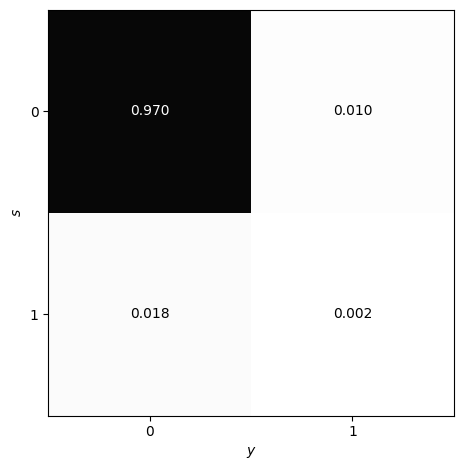

In [ ]:
# @title Plot
ss, yy, mesh = get_mesh(p0, q)
plt.figure()
ax = plt.subplot()
plt.pcolormesh(yy, ss, mesh, cmap='binary', vmin=0, vmax=1)
colors = np.where(mesh < 0.5, 'k', 'w')
for s,y,m,c in zip(ss.reshape(-1), yy.reshape(-1), mesh.reshape(-1), colors.reshape(-1)):
    text = ax.text(y,s, f"{m:.3f}",ha="center", va="center", color=c)
plt.xlabel("$y$"), plt.ylabel("$s$")
plt.xticks([0,1], labels=['0','1']), plt.yticks([0,1], labels=['0','1'])
plt.gca().set_box_aspect(1.0)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Bayes plays billard


* If you were to be shown a coin from which you don't know the Head probability, but you are said that it was flipped 10M times, and always returned Head, what would you think about its Head proba? Same question with 4M Heads returned, 6M Tails.
* The original Bayes billard table experiment, from Thomas Bayes, 1763, *[An Essay towards solving a Problem in the Doctrine of Chances](https://xianblog.wordpress.com/2011/05/02/re-reading-an-essay-towards-solving-a-problem-in-the-doctrine-of-chances/)*.
* Beta distribution is supported on $[0,1]$, and is both a continuous generalization of Bernoulli distribution, supported on $\{0,1\}$, and the uniform distribution on $[0,1]$. $$\begin{align*}
&\operatorname{\mathcal{B}\!eta}\left(1,1\right) \sim \mathcal{U}([0,1])\\
&\operatorname{\mathcal{B}\!eta}\left(\frac{q}{T}, \frac{1-q}{T}\right) \xrightarrow[T \to +\infty]{d} \operatorname{\mathcal{B}\!er}(q) \\
%&= C_1 A^\top \Sigma^{-1}(y - A\mu_0) + \mu_0 %less well-conditionned when C_0 \gg I
\end{align*}$$

* Then Beta model is$$\begin{gather*}
p(\obs \mid q)\;p(q) = p(q \mid \obs)\;p(\obs)\\
\iff\\
\underbrace{\operatorname{\cB\!er} (\obs \mid q)}_{\text{likelihood}}\;\underbrace{\operatorname{\cB\!eta}(q \mid \alpha_0, \beta_0)}_{\text{prior}} = \underbrace{\operatorname{\cB\!eta}(q \mid \alpha_1, \beta_1)}_{\text{posterior}}\; \underbrace{\operatorname{\cB\!er}\left(\obs \mid {\alpha_0}/({\alpha_0 + \beta_0})\right)}_{\text{evidence}}
\end{gather*}$$with$$\begin{align*}
\alpha_1&:= \obs + \alpha_0 \\
\beta_1&:= 1 -\obs + \beta_0\\
\end{align*}$$

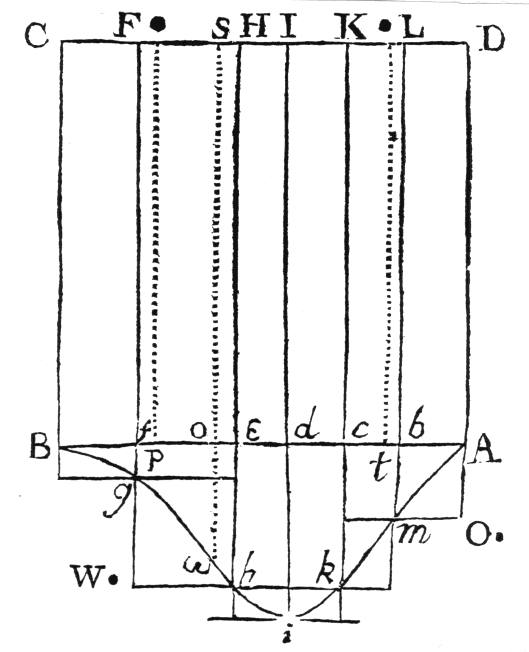

In [ ]:
# @title Define Bayesian update
def update_beta(y, a0, b0):
    a1 = y + a0
    b1 = 1 - y + b0
    return np.stack((a1, b1))

def get_mesh(a, b, n_disc=100):
    xs, ys = np.linspace(0,1,n_disc), np.linspace(0,1,n_disc)
    xy = np.meshgrid(xs, ys, indexing='ij')
    mesh = beta.pdf(xy[0], a[0],b[0]) * beta.pdf(xy[1], a[1],b[1])
    return np.stack((*xy, mesh))

def get_marg(a, b, n_disc=100):
    xs, ys = np.linspace(0,1,n_disc), np.linspace(0,1,n_disc)
    margx = beta.pdf(xs, a[0],b[0])
    margy = beta.pdf(ys, a[1],b[1])
    return np.stack(((xs, margx), (ys, margy)))

In [ ]:
# Prior and parameters
a, b = np.ones(2),np.ones(2)
true = np.array([3/4, 1/3])

# Observe
n_obs = 100
probes = beta.rvs(np.ones(2), np.ones(2), size=(n_obs,2))

# Plot settings
n_disc = 50
animate = True

In [ ]:
#@title Iterate Bayes
meshes = 2*[get_mesh(a, b, n_disc)]
marges = 2*[get_marg(a, b, n_disc)]
for probe in probes:
    y = probe < true # this is the observation
    a, b = update_beta(y, a, b)
    meshes.append(get_mesh(a, b, n_disc))
    marges.append(get_marg(a, b, n_disc))
meshes = np.stack(meshes)
marges = np.stack(marges)
meshes[0,-1], marges[0,:,-1] = 0,0

In [ ]:
#@title Plot
i = len(meshes)-1
plt.figure(figsize=(6, 6))
vmin, vmax = 0, marges.max()
gs = plt.GridSpec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = plt.subplot(gs[1, 0])
ax.set_xlim(0, 1), ax.set_ylim(0, 1)
ax.set_xlabel('$\\theta_1$'), ax.set_ylabel('$\\theta_2$')
ax.tick_params(labelbottom=False, labelleft=False)

axx = plt.subplot(gs[0, 0], sharex=ax)
axx.set_ylabel('$p(\\theta_1 \mid x_{1\!:\!n})$')
axx.set_ylim(vmin, vmax)
axx.tick_params(labelbottom=False, labelleft=False)

axy = plt.subplot(gs[1, 1], sharey=ax)
axy.set_xlim(vmin, vmax)
axy.set_xlabel('$p(\\theta_2 \mid x_{1\!:\!n})$')
axy.tick_params(labelbottom=False, labelleft=False)

quad = ax.pcolormesh(*meshes[i], cmap='viridis', vmin=0, vmax=np.quantile(meshes[:,-1], q=1))
path1 = ax.scatter(*true[None][:i].T, marker='x', c='r', label="true")
path2 = ax.scatter(*probes[:max(i-1,0)].T, marker='+', c='w', alpha=0.5, label="probe")
margx, margy = marges[i]
line1, = axx.plot(*margx)
line2, = axy.plot(*margy[::-1])

from matplotlib.lines import Line2D
handles, labels = ax.get_legend_handles_labels()
handles = handles[:-1]
handles.append(Line2D([], [], color='grey', marker='+', linestyle='', label='probe'))
leg2 = plt.gcf().legend(handles=handles, bbox_to_anchor=(0.906,0.832))
annot = ax.annotate(f'n={max(i-1,0)}', (0.02,0.94), color='w', size=14)

def update(i):
    if i < len(meshes):
        quad.set_array(meshes[i,-1])
        path1.set_offsets(true[None][:i])
        path2.set_offsets(probes[:max(i-1,0)])
        margx, margy = marges[i]
        line1.set_data(*margx)
        line2.set_data(*margy[::-1])
        annot.set_text(f'n={max(i-1,0)}')
    return quad, path1, path2, line1, line2

if animate:
    from matplotlib import animation, rc
    rc('animation', html='html5')
    anim = animation.FuncAnimation(plt.gcf(), update, frames=len(meshes)+20, interval=100, blit=True)
    plt.close(),
    display(anim)

### Gaussian Linear Model

* Let's infer the relation between two observed variables $\lat$ and $\obs$. For instance, we can assume a noised polynomial relation $$y = \mu_1 + \mu_2 x + \mu_3 x^2 + \ldots + \mu_d x^{d-1} + \cN(0,\Sigma)$$ This can be rewritten as a linear relation $y = A \mu + \cN(0,\Sigma)$, where $A$ is generaly called design matrix, and is in that case the $d$-th Vandermonde matrix of $x$, $$A:= \begin{bmatrix}
1 & x & x^2 & \dots & x^{d-1}\\
\end{bmatrix}$$

* This defines a gaussian likelihood, to which we add a gaussian prior on $\mu$ to obtain the Gaussian Linear Model$$\begin{gather*}
p(\obs \mid \mu)\;p(\mu) = p(\mu \mid \obs)\;p(\obs)\\
\iff\\
\underbrace{\cN (\obs \mid A\mu, \Sigma)}_{\text{likelihood}}\;\underbrace{\cN(\mu \mid \mu_0, C_0)}_{\text{prior}} = \underbrace{\cN(\mu \mid \mu_1, C_1)}_{\text{posterior}}\; \underbrace{\cN(\obs \mid A\mu_0, \Sigma + AC_0A\T)}_{\text{evidence}}
\end{gather*}$$
with$$\begin{align}
C_1&:= (A\T \Sigma^{-1} A + C_0^{-1})^{-1} \\
\mu_1 &:= C_1(A\T \Sigma^{-1} \obs + C_0^{-1} \mu_0)\\
%&= C_1 A\T \Sigma^{-1}(\obs - A\mu_0) + \mu_0 %less well-conditionned when C_0 \gg I
\end{align}$$

In [ ]:
#@title Define Bayesian update
def update_Gauss(y, mu0, C0, A, Sigma):
    A = np.atleast_2d(A)
    y = np.atleast_1d(y)
    invSigma = np.linalg.inv(Sigma)
    invC0 = np.linalg.inv(C0)
    C1 = np.linalg.inv(A.T @ invSigma @ A + invC0)
    mu1 = C1 @ (A.T @ invSigma @ y + invC0 @ mu0)
    return mu1, C1

def get_Apoly(x, order=2):
    pows = np.arange(order+1)
    return x[:,None]**pows

def get_ymean(get_A, mu, n_disc=100, xlim=[-1,1]):
    xs = np.linspace(*xlim,n_disc)
    return np.stack((xs, get_A(xs) @ mu))

def get_mesh_lat(mu, C, n_disc=100, mulim=2*[[-1,1]]):
    xs, ys = np.linspace(*mulim[0],n_disc), np.linspace(*mulim[1],n_disc)
    xy = np.meshgrid(xs, ys, indexing='ij')
    mesh = multivariate_normal.pdf(np.moveaxis(xy, 0,-1).reshape(-1,2), mu, C).reshape(xy[0].shape)
    return np.stack((*xy, mesh))

def get_mesh_pred(get_A, Sigma, mu, C, n_disc=100, xylim=2*[[-1,1]]):
    xs, ys = np.linspace(*xylim[0],n_disc), np.linspace(*xylim[1],n_disc)
    xx, yy = np.meshgrid(xs, ys, indexing='ij')
    A = get_A(xs)
    Cov = Sigma + (A @ C * A).sum(-1)
    mean = A @ mu
    mesh = norm.pdf(yy.T, mean, Cov).T
    return np.stack((xx, yy, mesh))

def get_level_pred(get_A, Sigma, mu, C, level=0.68, n_disc=100, xlim=[-1,1]):
    xs = np.linspace(*xlim,n_disc)
    A = get_A(xs)
    Cov = Sigma + (A @ C * A).sum(-1)
    mean = A @ mu
    coeff = norm.ppf((1+level)/2, 0,1)
    return np.stack((xs, mean-coeff*Cov[0], mean+coeff*Cov[0]))

def get_vlim(a, level=1., scale=1., axis=0):
    """Robust limits, i.e. bilateral quantile discarding and scaled margins."""
    a = np.array(a)
    vmin, vmax = jnp.quantile(a, (1-level)/2, axis=axis), jnp.quantile(a, (1+level)/2, axis=axis)
    vmean, vdiff = (vmax+vmin)/2, scale*(vmax-vmin)/2
    return jnp.stack((vmean-vdiff, vmean+vdiff), axis=-1)

def get_coord(Cov):
    """Coordinates of 2D covariance matrix in spectral space."""
    T, U = schur(Cov)
    lambds = np.diag(T)
    assert np.all(np.isclose(T, np.diag(lambds))), "Cov must be a covariance matrix."
    theta = np.arctan2(U[1,0], U[0,0])
    return np.stack([*lambds, theta])

def get_ellipse(Cov, mean=np.zeros(2), level=.68, n_disc=100):
    """Credible ellipse at given level in cartesian coordinates from covariance matrix."""
    radius = chi2.ppf(level, df=2)**.5
    coords = get_coord(Cov)
    rot = R.from_euler('z', coords[-1])
    u = np.linspace(0, 2*np.pi, n_disc)
    xy = radius * np.stack([np.cos(u), np.sin(u)])
    xy = np.moveaxis(xy, 0, -1) * coords[:2]**.5
    return np.moveaxis(xy @ rot.as_matrix()[:2,:2].T + mean, -1, 0)

In [ ]:
# Prior and parameters
dim = 3
mu, C = np.zeros(dim), np.eye(dim)
# C[2,2]=1e-10 # NOTE: can play with prior
# C[3,3]=1e-10
Sigma = np.eye(1)
mu_true = np.array([1.5,1,1/4,1/4**2,1/4**3])[:dim]
get_A = partial(get_Apoly, order=dim-1)

# Observe
n_obs = 64
x_obs = norm.rvs(0, 1, n_obs)
A_obs = get_A(x_obs)
y_obs = norm.rvs(A_obs @ mu_true, Sigma)
obs = np.stack((x_obs, y_obs), axis=-1)

# Plot settings
n_disc = 50
level = 0.95
animate = True

In [ ]:
#@title Iterate Bayes
scale = 1
alpha = 1
mulim = get_vlim([mu, mu_true], scale=2*scale)
mulim = np.array(2*[[np.min(mulim), np.max(mulim)]])
xlim = get_vlim(x_obs, scale=2.5*scale)
xs = np.linspace(*xlim, n_disc)
Amu_true = get_A(xs) @ mu_true
ylim = get_vlim(Amu_true, scale=1.25*scale)
xylim = np.stack((xlim, ylim))
y_true_mean = np.stack([xs, Amu_true], axis=-1)

# Iterate Bayes
meshes_lat = 2*[get_mesh_lat(mu[:2], C[:2,:2], n_disc, mulim)] # only get first two dimensions
level_lat = [get_ellipse(C[:2,:2], mu[:2], level, n_disc)]
mean_lat = [mu[:2]]
meshes_pred = 2*[get_mesh_pred(get_A, Sigma, mu, C, n_disc, xylim)]
level_pred = [get_level_pred(get_A, Sigma, mu, C, level, n_disc, xlim)]
mean_pred = [get_ymean(get_A, mu, n_disc, xlim)]

for A, y in zip(A_obs, y_obs):
    mu, C = update_Gauss(y, mu, C, A, Sigma)
    # Latent space
    meshes_lat.append(get_mesh_lat(mu[:2], C[:2,:2], n_disc, mulim)) # only get first two dimensions
    level_lat.append(get_ellipse(C[:2,:2], mu[:2], level, n_disc))
    mean_lat.append(mu[:2])
    # Predictive space
    meshes_pred.append(get_mesh_pred(get_A, Sigma, mu, C, n_disc, xylim))
    level_pred.append(get_level_pred(get_A, Sigma, mu, C, level, n_disc, xlim))
    mean_pred.append(get_ymean(get_A, mu, n_disc, xlim))
meshes_lat = np.stack(meshes_lat)
level_lat = np.stack(level_lat)
mean_lat = np.stack(mean_lat)
meshes_pred = np.stack(meshes_pred)
level_pred = np.stack(level_pred)
mean_pred = np.stack(mean_pred)
meshes_lat[0,-1], meshes_pred[0,-1] = 0,0

In [ ]:
#@title Plot
i=len(meshes_pred)-2
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
quad1 = ax1.pcolormesh(*meshes_pred[i], vmin=0, vmax=np.quantile(meshes_pred[:,-1], q=1))
line0, = ax1.plot(*y_true_mean.T, 'r', label="true mean")
path1 = ax1.scatter(*obs[:max(i-1,0)].T, c='chocolate', marker='+', label="obs")
lineHDR0, = ax1.plot(*level_pred[i,[0,1]], 'cyan', label=f"HDR {level:.0%}", alpha=alpha)
lineHDR1, = ax1.plot(*level_pred[i,[0,2]], 'cyan', alpha=alpha)
line1, = plt.plot(*mean_pred[i], ':', c='dodgerblue', label="mean")
plt.xlabel("$x$"), plt.ylabel("$y$")
plt.xlim(*xylim[0]), plt.ylim(*xylim[1])
plt.gca().set_box_aspect(1.0)
plt.legend(loc="upper left")
plt.title("Predictive space") # $p(y_{n+1} \mid x_{n+1}, (x,y)_{1\!:\!n})$

ax2 = plt.subplot(122)
quad2 = ax2.pcolormesh(*meshes_lat[i], vmin=0, vmax=np.quantile(meshes_lat[:,-1], q=1))
path2 = ax2.scatter(*mu_true[:2], c='r', marker='x', label="true")
line2, = ax2.plot(*level_lat[i], "cyan", label=f"HDR {level:.0%}", alpha=alpha)
path3 = ax2.scatter(*mean_lat[i], c='dodgerblue', marker='+', label="mean")
annot = ax2.annotate(f'n={max(i-1,0)}', (0.9*mulim[0,0],0.92*mulim[1,1]), color='w', size=14)
plt.xlabel("$\\theta_1$"), plt.ylabel("$\\theta_2$")
plt.xlim(*mulim[0]), plt.ylim(*mulim[1])
plt.gca().set_box_aspect(1.0)
plt.title("Latent space") # $p(\\theta \mid (x,y)_{1\!:\!n})$
plt.legend(loc="upper right")
plt.tight_layout()

def update(i):
    if i < len(meshes_pred):
        path2.set_offsets(mu_true[None][:i])
        quad2.set_array(meshes_lat[i,-1])
        line2.set_data(*level_lat[i-1:i].transpose(1,2,0))
        path3.set_offsets(mean_lat[i-1:i])

        line0.set_data(*y_true_mean[None][:i].T)
        path1.set_offsets(obs[:max(i-1,0)])
        quad1.set_array(meshes_pred[i,-1])
        lineHDR0.set_data(*level_pred[:,[0,1]][i-1:i].transpose(1,2,0))
        lineHDR1.set_data(*level_pred[:,[0,2]][i-1:i].transpose(1,2,0))
        line1.set_data(*mean_pred[i-1:i].transpose(1,2,0))
        annot.set_text(f'n={max(i-1,0)}')
    return quad1, quad2, path1, path2, path3, line0, lineHDR0, lineHDR1, line1, line2, annot

if animate:
    from matplotlib import animation, rc
    rc('animation', html='html5')
    anim = animation.FuncAnimation(plt.gcf(), update, frames=len(meshes_pred)+20, interval=100, blit=True)
    plt.close(),
    display(anim)

## Sampling

### (Very) simple isotropic cosmological model
* We assume a simple eulerian linear bias isotropic model
$$\delta_H(k) \simeq b\, \sigma_8\, \delta_L(k)$$
Let's assume the shape of $\delta_L(k)$ as already been taken into account, e.g. to constraint $\Omega_m$. The information left is its amplitude.

* The likelihood is thus $$\begin{align*}
\delta_H(k) \mid  b, \sigma_8 \sim \cN(0, (b\, \sigma_8\,\sigma_L(k))^2 I)\\
\end{align*}$$ which is not linear because of product between latent $b$ and $\sigma_8$.

* Moroever, discretization of the Fourrier space yields
$$\dd n(k) =\rho(k) \dd k \propto k^2 \dd k\quad \implies \quad\sigma_L(k) \propto n(k)^{-1/2} \propto  k^{-1}\sqrt{N_k}$$

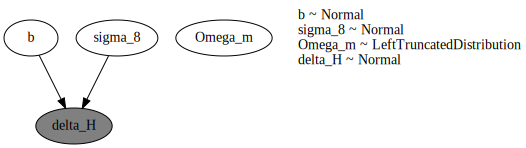

In [ ]:
# Define model and simulate
def model_iso(sigmas, std_omegam):
    b = sample('b', dist.Normal(2,0.1))
    sigma_8 = sample('sigma_8', dist.Normal(0.831,0.2))
    Omega_m = sample('Omega_m', dist.TruncatedNormal(0.25, std_omegam, low=0))
    transfer = b * sigma_8
    delta_H = sample('delta_H', dist.Normal(0, transfer**2 * sigmas**2))
    return delta_H

n_k = 100
std_omegam = 0.01 # NOTE: play with Omega_m information, e.g. std=0.01 vs. 0.1
fiduc = {'sigma_8':0.84, 'b':2.05, 'Omega_m':0.25}

ks = jnp.linspace(1e-1,0.3,n_k)
sigmas = 1e-3 * n_k**.5 / ks
config = dict(sigmas=sigmas, std_omegam=std_omegam)
model = partial(model_iso, **config)

# Simulate
obs = {'delta_H':seed(condition(model, fiduc), 42)()}
# Condition on observations
obs_model_iso = condition(model, obs)
# logp = lambda b, sigma_8: log_density(obs_model, (), {}, {'b':b, 'sigma_8':sigma_8})[0]
numpyro.render_model(obs_model_iso, render_distributions=True)

### Basic MCMC: Metropolis-Hastings

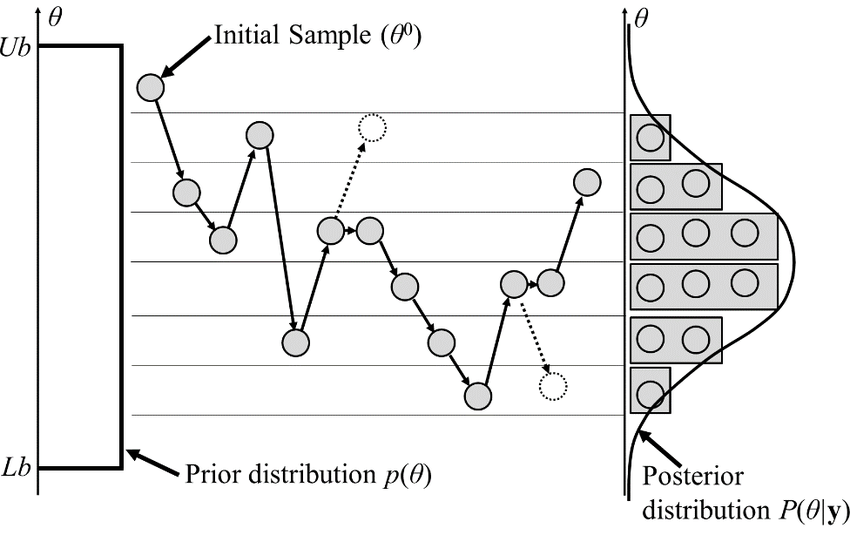

[demo](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana)

In [ ]:
from numpyro.contrib.tfp.mcmc import MetropolisAdjustedLangevinAlgorithm as MALA, RandomWalkMetropolis as MH
def new_state_fn(state, key):
    diffus = dist.Normal(jnp.zeros(3), 0.1*jnp.ones(3)).sample(key)
    return tree_map(lambda x,y:x+y, state, [diffus])

# Sample from posterior
mh_kernel = MH(model=obs_model_iso, init_strategy=infer.init_to_median(), new_state_fn=new_state_fn,)
mcmc =  infer.MCMC(mh_kernel, num_warmup=1000, num_samples=5000, progress_bar=True)
mcmc.run(jr.key(43))
samples_iso_mh = mcmc.get_samples()
mcmc.print_summary()

sample: 100%|██████████| 6000/6000 [00:02<00:00, 2370.26it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.25      0.01      0.25      0.23      0.27    344.16      1.00
         b      2.00      0.09      2.00      1.87      2.16    153.05      1.00
   sigma_8      0.89      0.05      0.88      0.81      0.96    173.37      1.00



### Gradient based MCMC: HMC

* To travel farther, add inertia
    1. Augment the sampling space by a momentum space.
    2. At each step sample a momentum
    3. Follow the Hamiltonian dynamic

* More formaly
    1. We augment the target $p(q \mid x_0)$ into $p(q , p \mid x_0) := e^{-H(q,p)}$, where $$H(q,p) := -\log p(q \mid x_0) + \frac 1 2 p^\top M^{-1} p$$
    2. At each proposal step, $p \sim \cN(0,M)$
	3. Follow the Hamiltonian trajectory for some length$$\dot q = \partial_p H \quad;\quad \dot p = -\partial_q H$$Then the arrival is the proposal.
* Way less correlated than MH, cf. [demo](https://arogozhnikov.github.io/2016/12/19/markov_chain_monte_carlo.html)



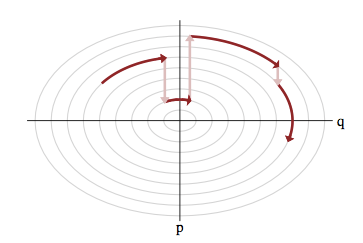
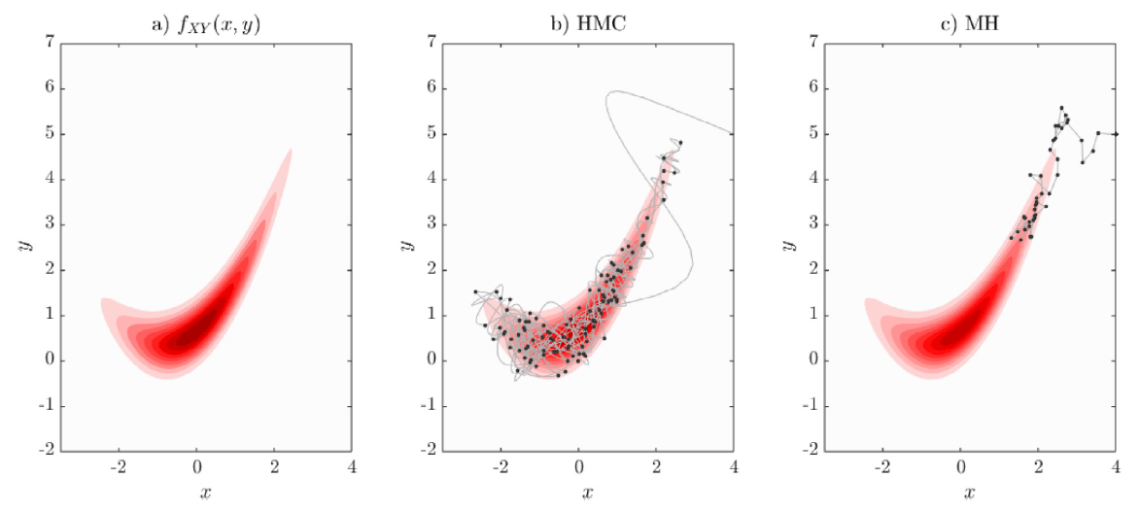

In [ ]:
# Sample from posterior
hmc_kernel = infer.HMC(obs_model_iso, step_size=0.1, init_strategy=infer.init_to_median(),)
mcmc =  infer.MCMC(hmc_kernel, num_warmup=1000, num_samples=5000, progress_bar=True)
mcmc.run(jr.key(43), extra_fields=['num_steps'])
samples_iso, extra = mcmc.get_samples(), mcmc.get_extra_fields()
print("total steps:", extra['num_steps'].sum())
# samples.update(extra)
mcmc.print_summary()

sample: 100%|██████████| 6000/6000 [00:04<00:00, 1441.08it/s, 14 steps of size 4.61e-01. acc. prob=0.96]


total steps: 70000

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.25      0.01      0.25      0.23      0.27  11976.32      1.00
         b      2.00      0.10      2.00      1.84      2.17   4223.86      1.00
   sigma_8      0.88      0.05      0.88      0.80      0.97   4173.95      1.00

Number of divergences: 0


Removed no burn in
Removed no burn in


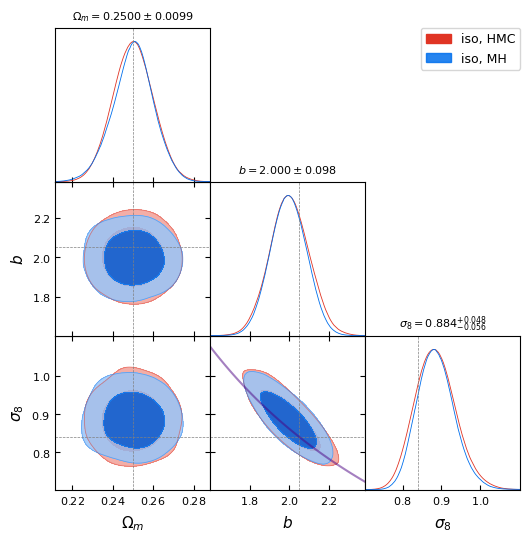

In [ ]:
labels = ["\Omega_m", "b","\sigma_8"]
gdsamp_iso    = MCSamples(samples=list(samples_iso.values()), names=list(samples_iso.keys()), labels=labels, label="iso, HMC")
gdsamp_iso_mh = MCSamples(samples=list(samples_iso_mh.values()), names=list(samples_iso_mh.keys()), labels=labels, label="iso, MH")
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(roots=[gdsamp_iso, gdsamp_iso_mh], title_limit=1, filled=True, markers=fiduc)
# Add degeneracy lines
ax = g.get_axes(ax=(2,1))
bs = np.linspace(*ax.get_xlim())
ax.plot(bs, fiduc['sigma_8'] * fiduc['b'] / bs, 'indigo', alpha=0.5)
plt.show()

### Let's add RSD: Kaiser model
* Kaiser model assumes$$\delta_H(k, \mu) \simeq (b + f \mu^2) \sigma_8\, \delta_L(k)$$where $\mu := \frac{k_{\text{los}}}{k} = \cos(\theta_{\text{los}})$ and we have the approximation $f \simeq \Omega_m^{0.55}$.

* The likelihood is thus $$\begin{align*}
\delta_H(k) \mid  b, \sigma_8 \sim \cN(0, ((b + f \mu^2) \sigma_8 \sigma_L(k))^2 I)\\
\end{align*}$$ which is still non linear.

* So with respect to $\mu$, $b \sigma_8$ and $f \sigma_8$ respectively sets the elevation and the slope of the observed variance, so this quantities can be well infered. And *a fortiori*, if $\Omega_m$ is well constrained, so is $f$, then so is $\sigma_8$, then so is $b$.

* Moroever, discretization of the Fourrier space yields
$$\dd n(k,\mu) =\rho(k,\mu) \dd k \, \dd \mu \propto k^2 \dd k\, \dd \mu \quad \implies \quad\sigma(k) \propto n(k)^{-1/2} \propto  k^{-1}\sqrt{N_k N_\mu}$$

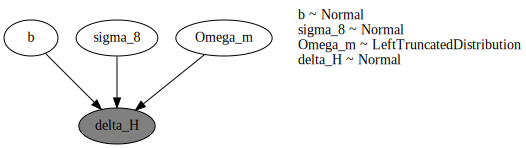

In [ ]:
# Define model and simulate
def model_kaiser(sigmas, mus, std_omegam):
    b = sample('b', dist.Normal(2,0.1))
    sigma_8 = sample('sigma_8', dist.Normal(0.831,0.2))
    Omega_m = sample('Omega_m', dist.TruncatedNormal(0.25, std_omegam, low=0))
    transfer = (b + Omega_m**0.55 * mus**2) * sigma_8
    delta_H = sample('delta_H', dist.Normal(0, transfer**2 * sigmas[:,None]**2))
    return delta_H

n_k, n_mu = 100, 20
ks, mus = jnp.linspace(1e-1,0.3,n_k), jnp.linspace(0,100,n_mu)
sigmas = 1e-3 * (n_k* n_mu)**.5 / ks
config = dict(sigmas=sigmas, mus=mus, std_omegam=std_omegam)
model = partial(model_kaiser, **config)

obs = {'delta_H':seed(condition(model, fiduc), 42)()}
obs_model_kaiser = condition(model, obs)
# logp = lambda b, sigma_8: log_density(obs_model, (), {}, {'b':b, 'sigma_8':sigma_8})[0]
numpyro.render_model(obs_model_kaiser, render_distributions=True)

In [ ]:
# Sample from posterior
hmc_kernel = infer.NUTS(obs_model_kaiser, step_size=0.1, init_strategy=infer.init_to_median(),)
mcmc =  infer.MCMC(hmc_kernel, num_warmup=1000, num_samples=5000, progress_bar=True)
mcmc.run(jr.key(43), extra_fields=['num_steps'])
samples_kaiser, extra = mcmc.get_samples(), mcmc.get_extra_fields()
print("total steps:", extra['num_steps'].sum())
# samples.update(extra)

sample: 100%|██████████| 6000/6000 [00:06<00:00, 932.03it/s, 7 steps of size 2.66e-01. acc. prob=0.93] 


total steps: 53330


Removed no burn in


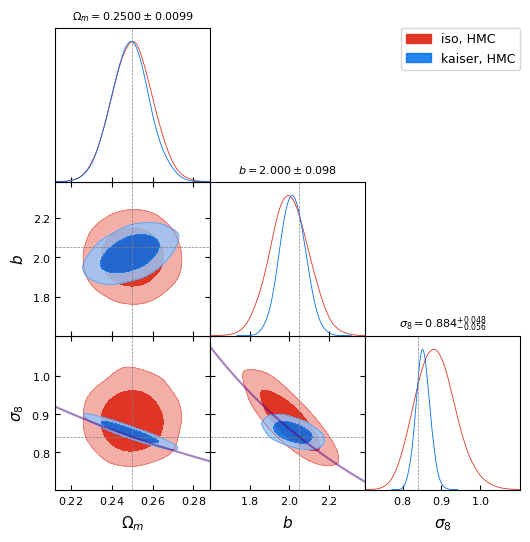

In [ ]:
labels = ["\Omega_m", "b","\sigma_8"]
gdsamp_kaiser = MCSamples(samples=list(samples_kaiser.values()), names=list(samples_kaiser.keys()), labels=labels, label="kaiser, HMC")
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(roots=[gdsamp_iso, gdsamp_kaiser], title_limit=1, filled=True, markers=fiduc)
# Add degeneracy lines
ax = g.get_axes(ax=(2,0))
Oms = np.linspace(*ax.get_xlim())
ax.plot(Oms, fiduc['sigma_8'] * fiduc['Omega_m']**0.55 / Oms**0.55, 'indigo', alpha=0.5)
ax = g.get_axes(ax=(2,1))
bs = np.linspace(*ax.get_xlim())
ax.plot(bs, fiduc['sigma_8'] * fiduc['b'] / bs, 'indigo', alpha=0.5)
plt.show()

## Food for thoughts


* How would random variables would interact togethers in a network? $% Bayesian Networks$
* How to account for causal relations? $% just with correlations w.r.t. independant actions$
* Is natural selection Bayesian optimization? $% true optimal is actually moving with the environment$
* Is the brain Bayesian? $%e.g. the Hamiltonian Brain, vs. bad at proba$
* What is the **logic** behind Bayes theorem? $% Bayes as classical logic extension$
* Actually, why do we care about the posterior? $% Decision theory$
* If you had no computing limit, which prior would you chose? $% Universal prior$
* How to deal with misspecification? $% Misspecified means true is not in support. Make it into support.$